In [1]:
import sys
sys.path.append("..")

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from utils.helper import *

In [3]:
df = pd.read_csv("../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

K = 5
df = scaled_data_vmd(df, _K=K)

target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

seq_len = 5
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

In [4]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

## CNN-BiLSTM

In [5]:
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim, conv_filters=64, conv_kernel=3, lstm_hidden=64, num_bilstm_layers=2, attn_heads=8, attn_dim=128, dropout=0.25):
        super().__init__()

        # CNN layers
        self.conv1 = nn.Conv1d(input_dim, conv_filters, kernel_size=conv_kernel, padding=conv_kernel//2)
        self.conv2 = nn.Conv1d(conv_filters, conv_filters, kernel_size=conv_kernel, padding=conv_kernel//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # BiLSTM layers
        self.bilstm = nn.LSTM(
            input_size=conv_filters,
            hidden_size=lstm_hidden,
            num_layers=num_bilstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_bilstm_layers > 1 else 0
        )

        # Projection to attention dimension
        self.proj = nn.Linear(2*lstm_hidden, attn_dim)

        # Multi-head attention
        self.attn = nn.MultiheadAttention(
            embed_dim=attn_dim,
            num_heads=attn_heads,
            batch_first=True,
            dropout=dropout
        )

        # Output layers
        self.out_fc = nn.Sequential(
            nn.Linear(attn_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        x = x.permute(0, 2, 1)              # (batch_size, input_dim, seq_len)

        # CNN layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.permute(0, 2, 1)              # (batch_size, seq_len, conv_filters)
        x = self.dropout(x)

        # BiLSTM
        lstm_out, _ = self.bilstm(x)        # (batch_size, seq_len, 2*lstm_hidden)

        # Project to attention dimension
        projected = self.proj(lstm_out)     # (batch_size, seq_len, attn_dim)

        # Self-attention
        attn_out, attn_weights = self.attn(projected, projected, projected)

        # Global average pooling over sequence dimension
        pooled = attn_out.mean(dim=1)       # (batch_size, attn_dim)

        # Output
        output = self.out_fc(pooled)        # (batch_size, 1)
        return output.squeeze(-1)

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [7]:
model = CNN_BiLSTM_Attention(input_dim=len(features))

In [8]:
decay_rate = 0.8
num_epochs = 500
learning_rate = 0.001
l2_penalty = 0.001

In [9]:
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(
#     optimizer,
#     gamma=decay_rate
# )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=decay_rate
)

In [10]:
best_val_loss = float('inf')
patience = 30
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), '../models/cnn_bilstm15.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 287361
Epoch 1/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


Epoch [1/500] - Train Loss: 1.117563, Val Loss: 20.362697
Epoch 2/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 224.02it/s]


Epoch [2/500] - Train Loss: 1.074665, Val Loss: 20.167609
Epoch 3/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 216.92it/s]


Epoch [3/500] - Train Loss: 1.046103, Val Loss: 19.573591
Epoch 4/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 227.07it/s]


Epoch [4/500] - Train Loss: 1.017855, Val Loss: 19.287563
Epoch 5/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 153.07it/s]


Epoch [5/500] - Train Loss: 0.771521, Val Loss: 15.020547
Epoch 6/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 231.35it/s]


Epoch [6/500] - Train Loss: 0.431840, Val Loss: 9.766981
Epoch 7/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 218.46it/s]


Epoch [7/500] - Train Loss: 0.281824, Val Loss: 10.054803
Epoch 8/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 163.46it/s]


Epoch [8/500] - Train Loss: 0.681560, Val Loss: 9.056674
Epoch 9/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 236.10it/s]


Epoch [9/500] - Train Loss: 0.815308, Val Loss: 19.155024
Epoch 10/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 203.96it/s]


Epoch [10/500] - Train Loss: 0.776935, Val Loss: 18.233236
Epoch 11/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 123.73it/s]


Epoch [11/500] - Train Loss: 0.638523, Val Loss: 16.090588
Epoch 12/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 226.60it/s]


Epoch [12/500] - Train Loss: 0.419984, Val Loss: 11.732484
Epoch 13/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 207.50it/s]


Epoch [13/500] - Train Loss: 0.256374, Val Loss: 7.383898
Epoch 14/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 207.27it/s]


Epoch [14/500] - Train Loss: 0.515683, Val Loss: 9.465791
Epoch 15/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 211.15it/s]


Epoch [15/500] - Train Loss: 0.392432, Val Loss: 10.803308
Epoch 16/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 234.41it/s]


Epoch [16/500] - Train Loss: 1.112350, Val Loss: 20.949680
Epoch 17/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 214.22it/s]


Epoch [17/500] - Train Loss: 0.915349, Val Loss: 19.487415
Epoch 18/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 219.39it/s]


Epoch [18/500] - Train Loss: 0.673010, Val Loss: 15.839586
Epoch 19/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 185.46it/s]


Epoch [19/500] - Train Loss: 0.439868, Val Loss: 12.043601
Epoch 20/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 215.35it/s]


Epoch [20/500] - Train Loss: 0.588514, Val Loss: 15.238502
Epoch 21/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 165.59it/s]


Epoch [21/500] - Train Loss: 0.704988, Val Loss: 15.670162
Epoch 22/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 222.75it/s]


Epoch [22/500] - Train Loss: 0.669102, Val Loss: 14.450163
Epoch 23/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 209.30it/s]


Epoch [23/500] - Train Loss: 0.658401, Val Loss: 15.093428
Epoch 24/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 188.38it/s]


Epoch [24/500] - Train Loss: 0.667994, Val Loss: 15.361237
Epoch 25/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 217.11it/s]


Epoch [25/500] - Train Loss: 0.749990, Val Loss: 15.719604
Epoch 26/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 206.68it/s]


Epoch [26/500] - Train Loss: 0.763171, Val Loss: 12.096676
Epoch 27/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 230.68it/s]


Epoch [27/500] - Train Loss: 0.755401, Val Loss: 16.573510
Epoch 28/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 196.29it/s]


Epoch [28/500] - Train Loss: 0.663912, Val Loss: 14.235140
Epoch 29/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 207.66it/s]


Epoch [29/500] - Train Loss: 0.621072, Val Loss: 11.787260
Epoch 30/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 194.04it/s]


Epoch [30/500] - Train Loss: 0.692751, Val Loss: 12.952141
Epoch 31/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 212.46it/s]


Epoch [31/500] - Train Loss: 0.738730, Val Loss: 14.454411
Epoch 32/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 204.10it/s]


Epoch [32/500] - Train Loss: 0.638077, Val Loss: 13.865949
Epoch 33/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 212.42it/s]


Epoch [33/500] - Train Loss: 0.711193, Val Loss: 14.919642
Epoch 34/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 201.69it/s]


Epoch [34/500] - Train Loss: 0.674700, Val Loss: 14.110635
Epoch 35/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 220.43it/s]


Epoch [35/500] - Train Loss: 0.679042, Val Loss: 15.158752
Epoch 36/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 213.49it/s]


Epoch [36/500] - Train Loss: 0.682114, Val Loss: 14.927497
Epoch 37/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 189.95it/s]


Epoch [37/500] - Train Loss: 0.686596, Val Loss: 15.452375
Epoch 38/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 22.91it/s]


Epoch [38/500] - Train Loss: 0.675921, Val Loss: 15.587967
Epoch 39/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 208.81it/s]


Epoch [39/500] - Train Loss: 0.745435, Val Loss: 16.004647
Epoch 40/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 207.11it/s]


Epoch [40/500] - Train Loss: 0.696372, Val Loss: 15.847534
Epoch 41/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 182.93it/s]


Epoch [41/500] - Train Loss: 0.692147, Val Loss: 15.386632
Epoch 42/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 212.47it/s]


Epoch [42/500] - Train Loss: 0.714071, Val Loss: 14.099500
Epoch 43/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 180.54it/s]

Epoch [43/500] - Train Loss: 0.675587, Val Loss: 14.301513
Early stopping triggered after epoch 43

Best validation loss: 7.383898


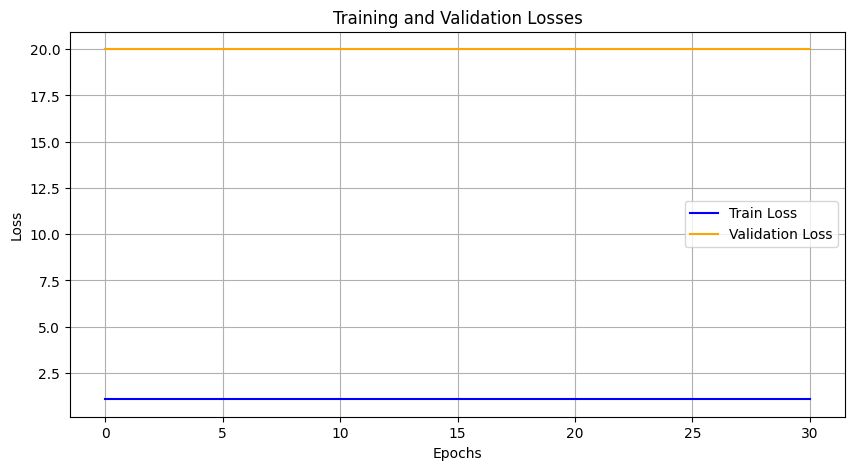

In [19]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [20]:
# Test phase
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 6.334011


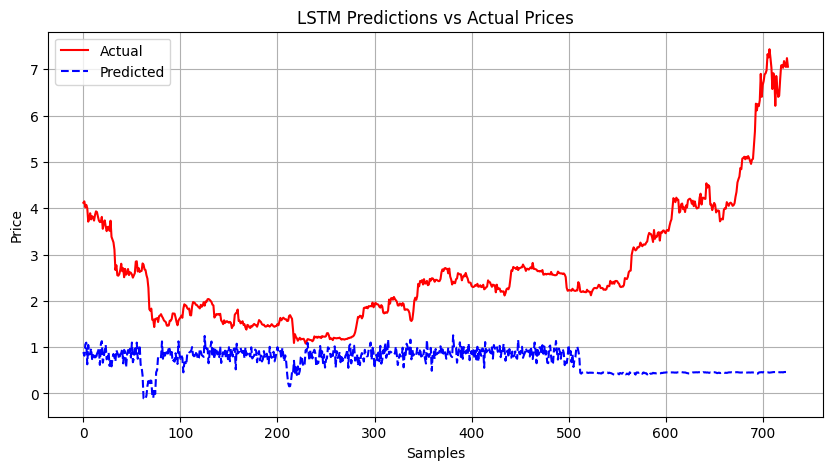

In [21]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()

In [14]:
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim, conv_filters=96, conv_kernel=3, lstm_hidden=12, num_bilstm_layers=2, attn_heads=4, attn_dim=64, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, conv_filters, kernel_size=conv_kernel, padding=conv_kernel//2)
        self.conv2 = nn.Conv1d(conv_filters, conv_filters, kernel_size=conv_kernel, padding=conv_kernel//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.bilstm = nn.LSTM(input_size=conv_filters, hidden_size=lstm_hidden, num_layers=num_bilstm_layers, batch_first=True, bidirectional=True)
        # Use PyTorch MultiheadAttention: needs embedding dim. We'll map BiLSTM outputs to attn_dim
        self.proj = nn.Linear(2*lstm_hidden, attn_dim)
        self.attn = nn.MultiheadAttention(embed_dim=attn_dim, num_heads=attn_heads, batch_first=True)
        self.out_fc = nn.Sequential(
            nn.Linear(attn_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: B,T,F
        x = x.permute(0,2,1)              # B,F,T
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.permute(0,2,1)              # B,T,conv_filters
        x = self.dropout(x)
        out, _ = self.bilstm(x)           # B,T,2*lstm_hidden
        proj = self.proj(out)             # B,T,attn_dim
        # MultiheadAttention expects (B, T, E) if batch_first=True
        attn_out, _ = self.attn(proj, proj, proj)  # self-attention
        # Pool (use last time step or mean)
        pooled = attn_out.mean(dim=1)     # B, attn_dim
        out = self.out_fc(pooled)         # B,1
        return out.squeeze(-1)


In [15]:
model2 = CNN_BiLSTM_Attention(input_dim=len(features))

In [16]:
model2 = model2.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

# scheduler = torch.optim.lr_scheduler.ExponentialLR(
#     optimizer,
#     gamma=decay_rate
# )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=decay_rate
)

In [17]:
best_val_loss = float('inf')
patience = 30
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model2.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model2.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model2(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    model2.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model2(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), '../models/cnn_bilstm15.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 88705
Epoch 1/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00,  7.41it/s]


Epoch [1/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 2/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 223.32it/s]


Epoch [2/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 3/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 249.19it/s]


Epoch [3/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 4/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 215.59it/s]


Epoch [4/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 5/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 260.26it/s]


Epoch [5/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 6/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.29it/s]


Epoch [6/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 7/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.12it/s]


Epoch [7/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 8/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 250.69it/s]


Epoch [8/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 9/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 230.25it/s]


Epoch [9/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 10/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 219.53it/s]


Epoch [10/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 11/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 234.05it/s]


Epoch [11/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 12/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 250.23it/s]


Epoch [12/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 13/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 252.94it/s]


Epoch [13/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 14/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 228.68it/s]


Epoch [14/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 15/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 241.89it/s]


Epoch [15/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 16/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 234.69it/s]


Epoch [16/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 17/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 242.81it/s]


Epoch [17/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 18/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 249.62it/s]


Epoch [18/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 19/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 249.76it/s]


Epoch [19/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 20/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 251.47it/s]


Epoch [20/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 21/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 238.64it/s]


Epoch [21/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 22/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 233.84it/s]


Epoch [22/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 23/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 224.85it/s]


Epoch [23/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 24/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 88.14it/s]


Epoch [24/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 25/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 217.29it/s]


Epoch [25/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 26/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 239.40it/s]


Epoch [26/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 27/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 147.97it/s]


Epoch [27/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 28/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 202.25it/s]


Epoch [28/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 29/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 253.75it/s]


Epoch [29/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 30/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 102.69it/s]


Epoch [30/500] - Train Loss: 1.076489, Val Loss: 19.996813
Epoch 31/500
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 253.55it/s]

Epoch [31/500] - Train Loss: 1.076489, Val Loss: 19.996813
Early stopping triggered after epoch 31

Best validation loss: 19.996813
